# Analisis Survival Breast Cancer MSK 2025

Notebook ini melakukan analisis survival pada data breast cancer dari MSK 2025, termasuk preprocessing data, pemodelan Cox Proportional Hazards, dan analisis Kaplan-Meier.

## Data Preparation

In [1]:
import pandas as pd
# Import file .tsv
df = pd.read_csv('breast_msk_2025_clinical_data.tsv', sep='\t')

# Tampilkan nama kolom
print("Nama kolom:")
print(df.columns.tolist())

Nama kolom:
['Study ID', 'Patient ID', 'Sample ID', 'Cancer Type', 'Cancer Type Detailed', 'Ethnicity', 'Fraction Genome Altered', 'Sex', 'Gene Panel', 'Metastatic Site', 'MSI Comment', 'MSI Score', 'MSI Type', 'Mutation Count', 'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status', 'Primary Tumor Site', 'Race', 'Sample Class', 'Number of Samples Per Patient', 'Sample coverage', 'Sample Type', 'Somatic Status', 'Tumor Purity']


## Data Loading

## Data Cleaning and Preprocessing

In [2]:
# Data Preprocessing

# Cek nilai unik di kolom 'Sex'
print("Nilai unik di kolom 'Sex' sebelum cleaning:")
print(df['Sex'].unique())

# Standardize nilai di kolom 'Sex' ke 'Male' dan 'Female'
df['Sex'] = df['Sex'].str.capitalize()  # Capitalize untuk membuat Female dan Male

# Pastikan hanya Male dan Female, drop atau handle lainnya jika ada
df = df[df['Sex'].isin(['Male', 'Female'])]

print("Nilai unik di kolom 'Sex' setelah cleaning:")
print(df['Sex'].unique())

# Cek nilai unik di kolom 'Overall Survival Status' sebelum mapping
print("Nilai unik di kolom 'Overall Survival Status' sebelum mapping:")
print(df['Overall Survival Status'].unique())

# Mengubah nilai di kolom 'Overall Survival Status' (pindah ke sini)
df['Overall Survival Status'] = df['Overall Survival Status'].map({'1:DECEASED': 1, '0:LIVING': 0})

# Tampilkan nilai unik setelah mapping untuk verifikasi
print("Nilai unik di kolom 'Overall Survival Status' setelah mapping:")
print(df['Overall Survival Status'].unique())

# Drop NaN di kolom yang diperlukan untuk analisis Cox dan KM
columns_needed = [
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Sex',
    'Primary Tumor Site',
    'MSI Type',
    'Mutation Count',
    'Fraction Genome Altered'
]
df = df.dropna(subset=columns_needed)

print(f"Jumlah sampel setelah preprocessing: {len(df)}")

Nilai unik di kolom 'Sex' sebelum cleaning:
['FEMALE' 'Female' 'Male' 'Unknown' 'MALE']
Nilai unik di kolom 'Sex' setelah cleaning:
['Female' 'Male']
Nilai unik di kolom 'Overall Survival Status' sebelum mapping:
['1:DECEASED' '0:LIVING']
Nilai unik di kolom 'Overall Survival Status' setelah mapping:
[1 0]
Jumlah sampel setelah preprocessing: 3656


# Kaplan-Meier Survival Analysis

### Survival Curve Comparison

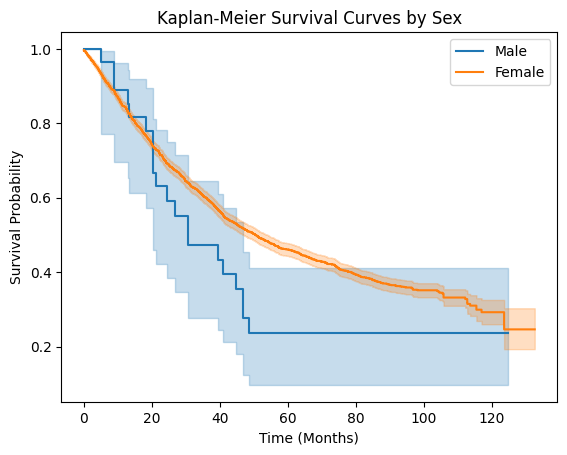

Jumlah Male: 30
Jumlah Female: 3626


In [3]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Buat Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Pisahkan data berdasarkan jenis kelamin
male = df[df['Sex'] == 'Male']
female = df[df['Sex'] == 'Female']

# Fit model untuk Male
kmf.fit(male['Overall Survival (Months)'], male['Overall Survival Status'], label='Male')
ax = kmf.plot()

# Fit model untuk Female
kmf.fit(female['Overall Survival (Months)'], female['Overall Survival Status'], label='Female')
kmf.plot(ax=ax)

# Tambahkan label dan judul
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curves by Sex')
plt.legend()
plt.show()

# Print jumlah sampel per kelompok
print(f"Jumlah Male: {len(male)}")
print(f"Jumlah Female: {len(female)}")

### Overall Survival Curve

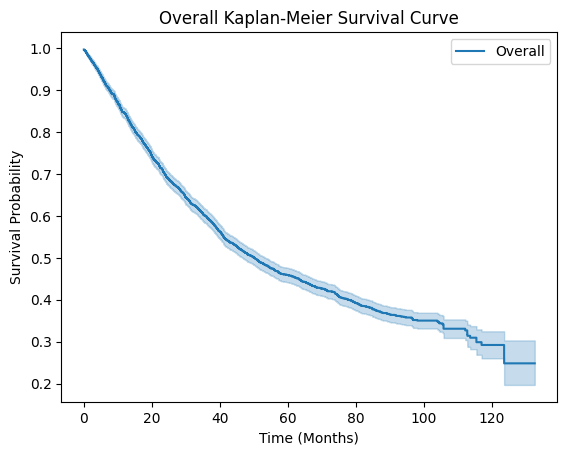

Median Survival Time (Overall): 50.13643686 months


In [4]:
# Overall Kaplan-Meier Survival Curve
kmf_overall = KaplanMeierFitter()
kmf_overall.fit(df['Overall Survival (Months)'], df['Overall Survival Status'], label='Overall')
kmf_overall.plot()
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Overall Kaplan-Meier Survival Curve')
plt.show()

# Median survival time overall
median_overall = kmf_overall.median_survival_time_
print(f"Median Survival Time (Overall): {median_overall} months")

### Median Survival Times

In [5]:
# Median survival times per group
kmf_male = KaplanMeierFitter()
kmf_male.fit(male['Overall Survival (Months)'], male['Overall Survival Status'])

kmf_female = KaplanMeierFitter()
kmf_female.fit(female['Overall Survival (Months)'], female['Overall Survival Status'])

median_male = kmf_male.median_survival_time_
median_female = kmf_female.median_survival_time_

print(f"Median Survival Time (Male): {median_male} months")
print(f"Median Survival Time (Female): {median_female} months")
print(f"Median Survival Time (Overall): {median_overall} months")

Median Survival Time (Male): 30.70651281 months
Median Survival Time (Female): 50.39944768 months
Median Survival Time (Overall): 50.13643686 months


### Survival Probability at Specific Time

In [6]:
# Contoh: Probabilitas survival pada 12 bulan
time_point = 12  # Ganti dengan n bulan yang diinginkan

# Untuk overall
prob_overall = kmf_overall.predict(time_point)
print(f"Survival Probability at {time_point} months (Overall): {prob_overall}")

# Untuk Male
prob_male = kmf_male.predict(time_point)
print(f"Survival Probability at {time_point} months (Male): {prob_male}")

# Untuk Female
prob_female = kmf_female.predict(time_point)
print(f"Survival Probability at {time_point} months (Female): {prob_female}")

Survival Probability at 12 months (Overall): 0.8451867034300574
Survival Probability at 12 months (Male): 0.8901098901098903
Survival Probability at 12 months (Female): 0.844821080945139


### Life Table

In [7]:
### Kaplan-Meier Life Table at Specific Times (Overall)
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48]

# Buat list untuk tabel
table_data = []
for time in time_points:
    survival_prob = kmf_overall.predict(time)
    at_risk = sum(df['Overall Survival (Months)'] >= time)
    deaths_cumulative = sum((df['Overall Survival (Months)'] <= time) & (df['Overall Survival Status'] == 1))
    table_data.append({
        'Time (Months)': time,
        'At Risk': at_risk,
        'Deaths (Observed, Cumulative)': deaths_cumulative,
        'Survival Probability': survival_prob
    })

# Buat DataFrame
life_table_specific = pd.DataFrame(table_data)

# Tampilkan tabel
print("Kaplan-Meier Life Table at Specific Times (Overall):")
print(life_table_specific)

Kaplan-Meier Life Table at Specific Times (Overall):
   Time (Months)  At Risk  Deaths (Observed, Cumulative)  Survival Probability
0              0     3656                             12              0.996718
1              6     3191                            282              0.919627
2             12     2892                            539              0.845187
3             18     2613                            793              0.770617
4             24     2338                           1038              0.697956
5             30     2131                           1219              0.643591
6             36     1950                           1366              0.598749
7             42     1742                           1545              0.543263
8             48     1608                           1650              0.510221


# Nelson Aalen

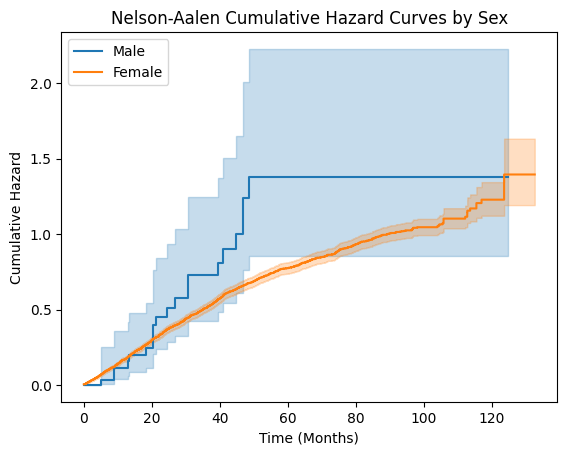

Cumulative Hazard Male at 50 months: 0.6868889250747214


In [8]:
from lifelines import NelsonAalenFitter
import matplotlib.pyplot as plt

# Buat Nelson-Aalen fitter
naf = NelsonAalenFitter()

# Pisahkan data berdasarkan jenis kelamin
male = df[df['Sex'] == 'Male']
female = df[df['Sex'] == 'Female']

# Fit dan plot cumulative hazard untuk Male
naf.fit(male['Overall Survival (Months)'], male['Overall Survival Status'], label='Male')
ax = naf.plot()

# Fit dan plot cumulative hazard untuk Female
naf.fit(female['Overall Survival (Months)'], female['Overall Survival Status'], label='Female')
naf.plot(ax=ax)

# Tambahkan label dan judul
plt.xlabel('Time (Months)')
plt.ylabel('Cumulative Hazard')
plt.title('Nelson-Aalen Cumulative Hazard Curves by Sex')
plt.legend()
plt.show()

# Untuk menampilkan nilai cumulative hazard pada waktu tertentu (misalnya, median survival)
# Ambil nilai pada waktu tertentu, contoh: pada 50 bulan
hazard_male_at_50 = naf.predict(50)  # Jika naf sudah fit untuk male
print(f"Cumulative Hazard Male at 50 months: {hazard_male_at_50}")
# Lakukan serupa untuk female

# Cox Regression

## Pemodelan Cox Regression

In [9]:
from lifelines import CoxPHFitter
import pandas as pd

# Pilih kolom yang diperlukan
columns_needed = [
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Sex',
    'Primary Tumor Site',
    'MSI Type',
    'Mutation Count',
    'Fraction Genome Altered'
]

# Buat subset data (sudah drop NaN di preprocessing)
data_cox = df[columns_needed]

# Pastikan tipe data benar
data_cox['Overall Survival (Months)'] = data_cox['Overall Survival (Months)'].astype(float)
data_cox['Overall Survival Status'] = data_cox['Overall Survival Status'].astype(int)

# Encode kolom kategorikal ke dummy variables
categorical_cols = ['Primary Tumor Site', 'MSI Type', 'Sex']
data_cox_encoded = pd.get_dummies(data_cox, columns=categorical_cols, drop_first=True)

# Tampilkan info data setelah encoding
print(f"Jumlah sampel setelah encoding: {len(data_cox_encoded)}")
print("Kolom setelah encoding:")
print(data_cox_encoded.columns.tolist())

# Fit model Cox Proportional Hazards
cph = CoxPHFitter(penalizer=0.1)  # Tambahkan penalizer untuk mengatasi kolinearitas
cph.fit(data_cox_encoded, duration_col='Overall Survival (Months)', event_col='Overall Survival Status')

# Tampilkan summary model
print("\nSummary Model Cox:")
print(cph.summary)

Jumlah sampel setelah encoding: 3656
Kolom setelah encoding:
['Overall Survival (Months)', 'Overall Survival Status', 'Mutation Count', 'Fraction Genome Altered', 'Primary Tumor Site_Cancer of Unknown Primary', 'Primary Tumor Site_breast', 'MSI Type_Indeterminate', 'MSI Type_Instable', 'MSI Type_Stable', 'Sex_Male']


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27384\233382060.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cox['Overall Survival (Months)'] = data_cox['Overall Survival (Months)'].astype(float)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_27384\233382060.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cox['Overall Survival Status'] = data_cox['Overall Survival Status'].astype(int)



Summary Model Cox:
                                                  coef  exp(coef)  se(coef)  \
covariate                                                                     
Mutation Count                                0.011995   1.012068  0.002169   
Fraction Genome Altered                       1.300205   3.670049  0.109609   
Primary Tumor Site_Cancer of Unknown Primary  1.197366   3.311382  1.010579   
Primary Tumor Site_breast                    -1.291587   0.274834  2.089064   
MSI Type_Indeterminate                        0.405691   1.500339  0.100882   
MSI Type_Instable                             0.117678   1.124882  0.323245   
MSI Type_Stable                               0.369321   1.446751  0.059364   
Sex_Male                                      0.269560   1.309388  0.213475   

                                              coef lower 95%  coef upper 95%  \
covariate                                                                      
Mutation Count               

In [10]:
# Lihat nilai unik di kolom kategorikal
print("Nilai unik di 'Primary Tumor Site':")
print(data_cox['Primary Tumor Site'].unique())

print("\nNilai unik di 'MSI Type':")
print(data_cox['MSI Type'].unique())

print("\nNilai unik di 'Sex':")
print(data_cox['Sex'].unique())

Nilai unik di 'Primary Tumor Site':
['Breast' 'Cancer of Unknown Primary' 'breast']

Nilai unik di 'MSI Type':
['Stable' 'Indeterminate' 'Do not report' 'Instable']

Nilai unik di 'Sex':
['Female' 'Male']


## Assumption Testing

In [11]:
# Uji asumsi proportional hazards
print("\nUji Asumsi Proportional Hazards:")
try:
    results = cph.check_assumptions(data_cox_encoded, p_value_threshold=0.05)
    print(results)
except Exception as e:
    print(f"Error dalam uji asumsi: {e}")


Uji Asumsi Proportional Hazards:
Proportional hazard assumption looks okay.
[]


In [12]:
# Concordance index
c_index = cph.concordance_index_
print(f"Concordance Index: {c_index}")

Concordance Index: 0.6077258353713104


## Baseline Hazard

In [14]:
# Ekstrak baseline hazard
baseline_hazard = cph.baseline_cumulative_hazard_
print("Baseline Hazard Function h0(t):")
print(baseline_hazard)

Baseline Hazard Function h0(t):
            baseline cumulative hazard
0.000000                      0.003131
0.065753                      0.003670
0.098629                      0.004209
0.131505                      0.004749
0.164382                      0.005019
...                                ...
129.302693                    1.406767
129.434198                    1.406767
130.223230                    1.406767
130.288983                    1.406767
132.656081                    1.406767

[1858 rows x 1 columns]


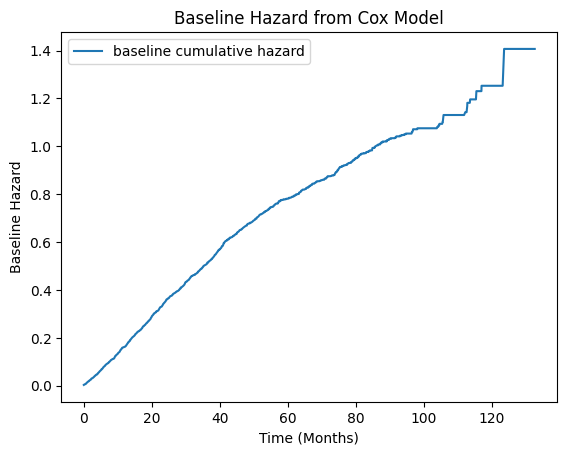

In [15]:
baseline_hazard.plot()
plt.xlabel('Time (Months)')
plt.ylabel('Baseline Hazard')
plt.title('Baseline Hazard from Cox Model')
plt.show()

## Conclusion

Analisis survival breast cancer MSK 2025 telah selesai, termasuk preprocessing data, pemodelan Cox Proportional Hazards, dan perbandingan kurva Kaplan-Meier berdasarkan jenis kelamin. Periksa hasil uji asumsi dan interpretasi model untuk wawasan lebih lanjut.